## Outline
#### Ensure columns are formatted correctly
#### Create Features
#### Separate into train/test data
#### Create initial model
#### Evaluate model
#### Tune hyperparameters
#### Create Predictions for 2025


In [51]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

In [671]:
QBs = pd.read_csv('/Users/alexanderlarson/Desktop/Python Projects/Fantasy Football Rankings/Fantasyfb_Data/QBs.csv')
RBs =pd.read_csv('/Users/alexanderlarson/Desktop/Python Projects/Fantasy Football Rankings/Fantasyfb_Data/RBs.csv')
WRs = pd.read_csv('/Users/alexanderlarson/Desktop/Python Projects/Fantasy Football Rankings/Fantasyfb_Data/WRs.csv')
TEs = pd.read_csv('/Users/alexanderlarson/Desktop/Python Projects/Fantasy Football Rankings/Fantasyfb_Data/TEs.csv')

In [672]:
QBs.drop(columns=['Unnamed: 0', 'Tgt_gm'], inplace=True)
RBs.drop(columns=['Unnamed: 0', 'Tgt_Binned', 'Att_Rush_Binned', 'PPR_PassAtt'], inplace=True)
WRs.drop(columns=['Unnamed: 0', 'PPR_PassAtt'], inplace=True)
TEs.drop(columns=['Unnamed: 0', 'PPR_PassAtt'], inplace=True)

## QBs model

#### Creating Features

In [415]:
QBs = QBs.sort_values(['Player', 'Year'])

In [ ]:
# Career Stats

QBs['Career_Pass_Att'] = QBs.groupby('Player')['Att_Pass'].cumsum().shift(1)
QBs['Career_Pass_Att'] = QBs['Career_Pass_Att'].fillna(0)

QBs['Career_Avg_PPR'] = QBs.groupby('Player')['PPR'].expanding().mean().shift(1).reset_index(level=0, drop=True)
QBs['Career_Avg_PPR'] = QBs['Career_Avg_PPR'].fillna(0)

QBs['Career_Avg_PassRating'] = QBs.groupby('Player')['Passer_Rating'].expanding().mean().shift(1).reset_index(level=0, drop=True)
QBs['Career_Avg_PassRating'] = QBs['Career_Avg_PassRating'].fillna(0)

#Lagged Stats
QBs['Cmp_last_year'] = QBs.groupby('Player')['Cmp'].shift(1)
QBs['Cmp_2_years'] = QBs.groupby('Player')['Cmp'].shift(2)

QBs['Att_Pass_last_year'] = QBs.groupby('Player')['Att_Pass'].shift(1)
QBs['Att_Pass_2_years'] = QBs.groupby('Player')['Att_Pass'].shift(2)

QBs['Yds_Pass_last_year'] = QBs.groupby('Player')['Yds_Pass'].shift(1)
QBs['Yds_Pass_2_years'] = QBs.groupby('Player')['Yds_Pass'].shift(2)

QBs['Att_Rush_last_year'] = QBs.groupby('Player')['Att_Rush'].shift(1)
QBs['Att_Rush_2_years'] = QBs.groupby('Player')['Att_Rush'].shift(2)

QBs['Yds_Rush_last_year'] = QBs.groupby('Player')['Yds (Rush)'].shift(1)
QBs['Yds_Rush_2_years'] = QBs.groupby('Player')['Yds (Rush)'].shift(2)

QBs['TD_last_year'] = QBs.groupby('Player')['TD'].shift(1)
QBs['TD_2_years'] = QBs.groupby('Player')['TD'].shift(2)

QBs['Snaps_last_year'] = QBs.groupby('Player')['Total_Snaps'].shift(1)
QBs['Snaps_2_years'] = QBs.groupby('Player')['Total_Snaps'].shift(2)

QBs['PassRating_last_year'] = QBs.groupby('Player')['Passer_Rating'].shift(1)
QBs['PassRating_2_years'] = QBs.groupby('Player')['Passer_Rating'].shift(2)

#Lagged Fantasy Points for Testing
QBs['PPR_next_year'] = QBs.groupby('Player')['PPR'].shift(-1)
QBs_train = QBs[QBs['Year'] < 2023].dropna(subset=['PPR_next_year'])
QBs_val = QBs[QBs['Year'] == 2023].dropna(subset=['PPR_next_year'])
QBs_test = QBs[QBs['Year'] == 2024]

In [400]:
QBs.columns

Index(['Player', 'Tm', 'Age', 'G', 'GS', 'Cmp', 'Att_Pass', 'Yds_Pass',
       'TD (Pass)', 'Int', 'Att_Rush', 'Yds (Rush)', 'Y/A', 'TD (Rush)', 'Fmb',
       'FL', 'TD', '2PM', '2PP', 'PPR', 'Total_Snaps', 'Avg Snaps',
       'TM SNAP %', 'PPR (Pass)', 'PPR_PassAtt', 'Y/A (Pass)', 'PPR_Rush',
       'PPR_RushAtt', 'PPR_Snap', 'Passer_Rating', 'Year', 'TD_Pct',
       'Career_Pass_Att', 'Career_Avg_PPR', 'Career_Avg_PassRating',
       'Cmp_last_year', 'Cmp_2_years', 'Att_Pass_last_year',
       'Att_Pass_2_years', 'Yds_Pass_last_year', 'Yds_Pass_2_years',
       'Att_Rush_last_year', 'Att_Rush_2_years', 'Yds_Rush_last_year',
       'Yds_Rush_2_years', 'TD_last_year', 'TD_2_years', 'Snaps_last_year',
       'Snaps_2_years', 'PassRating_last_year', 'PassRating_2_years',
       'PPR_next_year'],
      dtype='object')

#### Creating Initial Model

In [741]:
QBs_Features = ['Age', 'Cmp', 'Att_Pass', 'Yds_Pass', 'Att_Rush', 'Yds (Rush)',
                'TD', 'Total_Snaps', 'Passer_Rating','Career_Pass_Att', 'Career_Avg_PPR',
                'Career_Avg_PassRating', 'Cmp_last_year', 'Cmp_2_years', 'Att_Pass_last_year', 'Att_Pass_2_years',
                'Yds_Pass_last_year', 'Yds_Pass_2_years', 'Att_Rush_last_year', 'Att_Rush_2_years', 'Yds_Rush_last_year',
                'Yds_Rush_2_years', 'TD_last_year', 'TD_2_years',
                'Snaps_last_year', 'Snaps_2_years', 'PassRating_last_year', 'PassRating_2_years']

X_train, y_train = QBs_train[QBs_Features], QBs_train['PPR_next_year']
X_val,   y_val   = QBs_val[QBs_Features],   QBs_val['PPR_next_year']
X_test           = QBs_test[QBs_Features]


In [742]:
model = xgb.XGBRegressor(
    n_estimators = 100,
    learning_rate = 0.05,
    max_depth = 3,
    subsample = 0.8,
    colsample_bytree = 0.8,
    reg_lambda = 10,
    reg_alpha = 0,
    random_state =3
)

model.fit(X_train,y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [743]:
# Training predictions
train_preds = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
train_r2 = r2_score(y_train, train_preds)

# Validation predictions
val_preds = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
val_r2 = r2_score(y_val, val_preds)

print("Training RMSE:", train_rmse)
print("Training R²:", train_r2)
print("Validation RMSE:", val_rmse)
print("Validation R²:", val_r2)



Training RMSE: 58.18340231489302
Training R²: 0.7803522192082147
Validation RMSE: 78.52371139126376
Validation R²: 0.5675659553472256


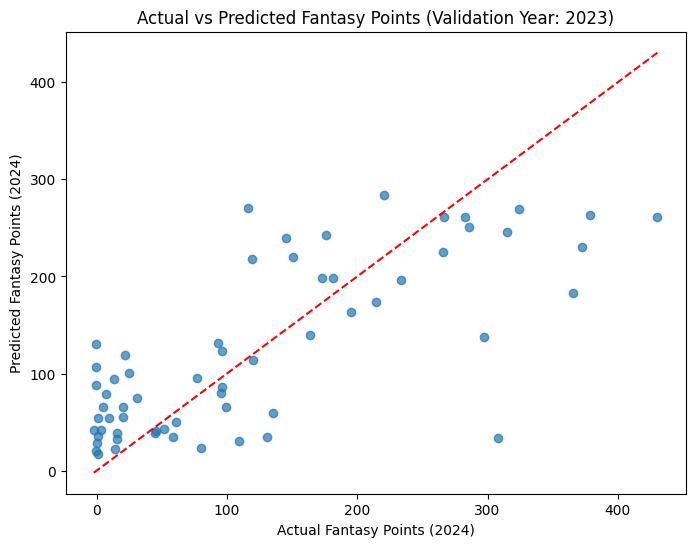

In [412]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_val, val_preds, alpha=0.7)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # perfect prediction line
plt.xlabel("Actual Fantasy Points (2024)")
plt.ylabel("Predicted Fantasy Points (2024)")
plt.title("Actual vs Predicted Fantasy Points (Validation Year: 2023)")
plt.show()


In [744]:
# Get feature importances
importance = model.feature_importances_

# Put into a DataFrame for readability
importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print(importances_df.head(15))  # Top 15 features

                  Feature  Importance
3                Yds_Pass    0.203712
7             Total_Snaps    0.168095
1                     Cmp    0.101399
8           Passer_Rating    0.040067
16     Yds_Pass_last_year    0.031729
24        Snaps_last_year    0.031289
18     Att_Rush_last_year    0.029932
5              Yds (Rush)    0.027337
0                     Age    0.026638
4                Att_Rush    0.025490
17       Yds_Pass_2_years    0.024231
14     Att_Pass_last_year    0.023590
11  Career_Avg_PassRating    0.022870
26   PassRating_last_year    0.021635
12          Cmp_last_year    0.020471


#### 2025 Predictions QBs

In [413]:
future_preds = model.predict(X_test)
QBs_test['2025_Fantasy_Projection'] = future_preds

/var/folders/c4/n46xtynn6dzcwnjhrstwv38w0000gn/T/ipykernel_13426/4164295603.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  QBs_test['2025_Fantasy_Projection'] = future_preds


## RBs model

#### Creating Features

In [726]:
RBs = RBs.sort_values(['Player', 'Year'])

In [727]:
# Career Stats

RBs['Career_Att_Rush'] = RBs.groupby('Player')['Att_Rush'].cumsum().shift(1)
RBs['Career_Att_Rush'] = RBs['Career_Att_Rush'].fillna(0)

RBs['Career_Avg_PPR'] = RBs.groupby('Player')['PPR'].expanding().mean().shift(1).reset_index(level=0, drop=True)
RBs['Career_Avg_PPR'] = RBs['Career_Avg_PPR'].fillna(0)

RBs['Career_Avg_Y/A'] = RBs.groupby('Player')['Y/A'].expanding().mean().shift(1).reset_index(level=0, drop=True)
RBs['Career_Avg_Y/A'] = RBs['Career_Avg_Y/A'].fillna(0)

#Lagged Stats
RBs['Att_Rush_last_year'] = RBs.groupby('Player')['Att_Rush'].shift(1)
RBs['Att_Rush_2_years'] = RBs.groupby('Player')['Att_Rush'].shift(2)

RBs['Yds_Rush_last_year'] = RBs.groupby('Player')['Yds (Rush)'].shift(1)
RBs['Yds_Rush_2_years'] = RBs.groupby('Player')['Yds (Rush)'].shift(2)

RBs['TD_last_year'] = RBs.groupby('Player')['TD'].shift(1)
RBs['TD_2_years'] = RBs.groupby('Player')['TD'].shift(2)

RBs['Snaps_last_year'] = RBs.groupby('Player')['Total_Snaps'].shift(1)
RBs['Snaps_2_years'] = RBs.groupby('Player')['Total_Snaps'].shift(2)

RBs['Tgt_last_year'] = RBs.groupby('Player')['Tgt'].shift(1)
RBs['Tgt_2_years'] = RBs.groupby('Player')['Tgt'].shift(2)

RBs['Rec_last_year'] = RBs.groupby('Player')['Rec'].shift(1)
RBs['Rec_2_years'] = RBs.groupby('Player')['Rec'].shift(2)

RBs['Yds_rec_last_year'] = RBs.groupby('Player')['Yds_Rec'].shift(1)
RBs['Yds_rec_2_years'] = RBs.groupby('Player')['Yds_Rec'].shift(2)

#Lagged Fantasy Points for Testing
RBs['PPR_next_year'] = RBs.groupby('Player')['PPR'].shift(-1)
RBs_train = RBs[RBs['Year'] < 2023].dropna(subset=['PPR_next_year'])
RBs_val = RBs[RBs['Year'] == 2023].dropna(subset=['PPR_next_year'])
RBs_test = RBs[RBs['Year'] == 2024]

In [417]:
RBs.columns

Index(['Player', 'Tm', 'Age', 'G', 'GS', 'Att_Rush', 'Yds (Rush)', 'Y/A',
       'TD (Rush)', 'Tgt', 'Rec', 'Yds_Rec', 'Yds_per_rec', 'TD (Rec)', 'Fmb',
       'FL', 'TD', '2PM', '2PP', 'PPR', 'Total_Snaps', 'Avg Snaps',
       'TM SNAP %', 'PPR_Rush', 'PPR_RushAtt', 'Tot_PPR_Rec', 'PPR_Tgt',
       'Tgt_gm', 'PPR_Rec', 'PPR_Snap', 'Year', 'Career_Att_Rush',
       'Career_Avg_PPR', 'Career_Avg_Y/A', 'Att_Rush_last_year',
       'Att_Rush_2_years', 'Yds_Rush_last_year', 'Yds_Rush_2_years',
       'TD_last_year', 'TD_2_years', 'Snaps_last_year', 'Snaps_2_years',
       'Tgt_last_year', 'Tgt_2_years', 'Rec_last_year', 'Rec_2_years',
       'Yds_rec_last_year', 'Yds_rec_2_years', 'PPR_next_year'],
      dtype='object')

#### Creating Model

In [737]:
RBs_Features = ['Age', 'Att_Rush', 'Y/A', 'Yds (Rush)','Tgt', 'Rec', 'Yds_Rec',
                'TD','TD_last_year','TD_2_years',
                'Total_Snaps','Career_Att_Rush',
       'Career_Avg_PPR', 'Career_Avg_Y/A', 'Att_Rush_last_year',
       'Yds_Rush_last_year', 'Snaps_last_year',
       'Tgt_last_year', 'Rec_last_year',  'Yds_rec_last_year',
       'Att_Rush_2_years', 'Yds_Rush_2_years','Snaps_2_years',
       'Tgt_2_years', 'Rec_2_years', 'Yds_rec_2_years'
       ]

X_train, y_train = RBs_train[RBs_Features], RBs_train['PPR_next_year']
X_val, y_val = RBs_val[RBs_Features], RBs_val['PPR_next_year']
X_test       = RBs_test[RBs_Features]

In [738]:
model = xgb.XGBRegressor(
    n_estimators = 350,
    learning_rate = 0.05,
    max_depth = 2,
    subsample = 0.8,
    colsample_bytree = 0.8,
    reg_lambda = 10,
    reg_alpha = 1,
    random_state =3
)

model.fit(X_train,y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [739]:
# Training predictions
train_preds = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
train_r2 = r2_score(y_train, train_preds)

# Validation predictions
val_preds = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
val_r2 = r2_score(y_val, val_preds)

print("Training RMSE:", train_rmse)
print("Training R²:", train_r2)
print("Validation RMSE:", val_rmse)
print("Validation R²:", val_r2)

Training RMSE: 49.13464786785576
Training R²: 0.6960168021209725
Validation RMSE: 68.45371868525362
Validation R²: 0.5051646039789286


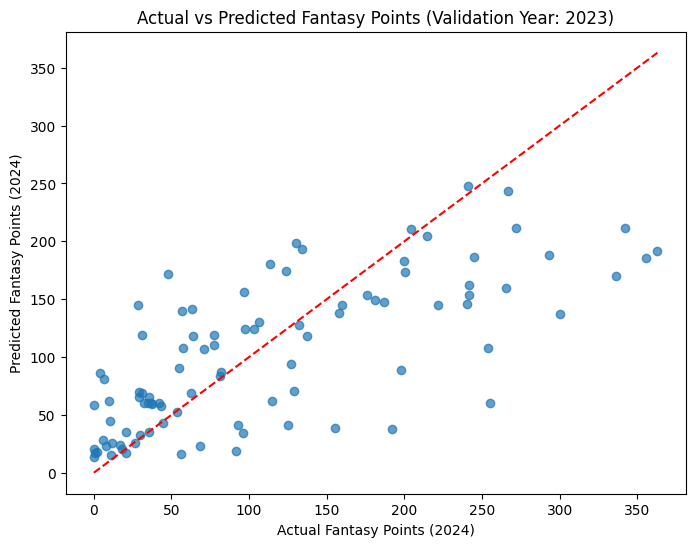

In [731]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_val, val_preds, alpha=0.7)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # perfect prediction line
plt.xlabel("Actual Fantasy Points (2024)")
plt.ylabel("Predicted Fantasy Points (2024)")
plt.title("Actual vs Predicted Fantasy Points (Validation Year: 2023)")
plt.show()


In [740]:
# Get feature importances
importance = model.feature_importances_

# Put into a DataFrame for readability
importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print(importances_df.head(15))  # Top 15 features

             Feature  Importance
3         Yds (Rush)    0.204586
7                 TD    0.095579
6            Yds_Rec    0.081882
10       Total_Snaps    0.071053
24       Rec_2_years    0.052907
5                Rec    0.047431
0                Age    0.041072
2                Y/A    0.031055
21  Yds_Rush_2_years    0.026484
23       Tgt_2_years    0.025527
1           Att_Rush    0.025423
4                Tgt    0.025003
22     Snaps_2_years    0.024293
8       TD_last_year    0.023163
16   Snaps_last_year    0.022533


#### 2025 Predictions

In [732]:
future_preds = model.predict(X_test)
RBs_test['2025_Fantasy_Projection'] = future_preds

/var/folders/c4/n46xtynn6dzcwnjhrstwv38w0000gn/T/ipykernel_13426/3481768187.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RBs_test['2025_Fantasy_Projection'] = future_preds


## WRs Model

#### Creating Features

In [709]:
WRs = WRs.sort_values(['Player', 'Year'])

In [710]:
# Career Stats

WRs['Career_Tgt'] = WRs.groupby('Player')['Tgt'].cumsum().shift(1)
WRs['Career_Tgt'] = WRs['Career_Tgt'].fillna(0)

WRs['Career_Avg_PPR'] = WRs.groupby('Player')['PPR'].expanding().mean().shift(1).reset_index(level=0, drop=True)
WRs['Career_Avg_PPR'] = WRs['Career_Avg_PPR'].fillna(0)

WRs['Career_Avg_Yds_per_rec'] = WRs.groupby('Player')['Yds_per_rec'].expanding().mean().shift(1).reset_index(level=0, drop=True)
WRs['Career_Avg_Yds_per_rec'] = WRs['Career_Avg_Yds_per_rec'].fillna(0)

#Lagged Stats
WRs['Att_Rush_last_year'] = WRs.groupby('Player')['Att_Rush'].shift(1)
WRs['Att_Rush_2_years'] = WRs.groupby('Player')['Att_Rush'].shift(2)

WRs['Yds_Rush_last_year'] = WRs.groupby('Player')['Yds (Rush)'].shift(1)
WRs['Yds_Rush_2_years'] = WRs.groupby('Player')['Yds (Rush)'].shift(2)

WRs['TD_last_year'] = WRs.groupby('Player')['TD'].shift(1)
WRs['TD_2_years'] = WRs.groupby('Player')['TD'].shift(2)

WRs['Snaps_last_year'] = WRs.groupby('Player')['Total_Snaps'].shift(1)
WRs['Snaps_2_years'] = WRs.groupby('Player')['Total_Snaps'].shift(2)

WRs['Tgt_last_year'] = WRs.groupby('Player')['Tgt'].shift(1)
WRs['Tgt_2_years'] = WRs.groupby('Player')['Tgt'].shift(2)

WRs['Rec_last_year'] = WRs.groupby('Player')['Rec'].shift(1)
WRs['Rec_2_years'] = WRs.groupby('Player')['Rec'].shift(2)

WRs['Yds_rec_last_year'] = WRs.groupby('Player')['Yds_Rec'].shift(1)
WRs['Yds_rec_2_years'] = WRs.groupby('Player')['Yds_Rec'].shift(2)

#Lagged Fantasy Points for Testing
WRs['PPR_next_year'] = WRs.groupby('Player')['PPR'].shift(-1)
WRs_train = WRs[WRs['Year'] < 2023].dropna(subset=['PPR_next_year'])
WRs_val = WRs[WRs['Year'] == 2023].dropna(subset=['PPR_next_year'])
WRs_test = WRs[WRs['Year'] == 2024]

In [469]:
WRs.columns

Index(['Player', 'Tm', 'Age', 'G', 'GS', 'Att_Rush', 'Yds (Rush)', 'Y/A',
       'TD (Rush)', 'Tgt', 'Rec', 'Yds_Rec', 'Yds_per_rec', 'TD (Rec)', 'Fmb',
       'FL', 'TD', '2PM', '2PP', 'PPR', 'Total_Snaps', 'Avg Snaps',
       'TM SNAP %', 'PPR_Rush', 'PPR_RushAtt', 'Tot_PPR_Rec', 'PPR_Tgt',
       'Tgt_gm', 'PPR_Rec', 'PPR_Snap', 'Year', 'PPR_Yards_Only', 'Career_Tgt',
       'Career_Avg_PPR', 'Career_Avg_Yds_per_rec', 'Att_Rush_last_year',
       'Att_Rush_2_years', 'Yds_Rush_last_year', 'Yds_Rush_2_years',
       'TD_last_year', 'TD_2_years', 'Snaps_last_year', 'Snaps_2_years',
       'Tgt_last_year', 'Tgt_2_years', 'Rec_last_year', 'Rec_2_years',
       'Yds_rec_last_year', 'Yds_rec_2_years', 'PPR_next_year'],
      dtype='object')

#### Creating the model

In [733]:
WRs_Features = ['Age', 'Tgt', 'Rec', 'Yds_Rec', 'Yds_per_rec',
                'TD', 'TD_last_year',
                'TD_2_years',
                'Total_Snaps', 'TM SNAP %','Career_Tgt', 'Career_Avg_PPR', 'Career_Avg_Yds_per_rec',
                'Snaps_last_year', 'Tgt_last_year', 'Rec_last_year','Yds_rec_last_year',
                'Yds_rec_2_years','Rec_2_years','Tgt_2_years','Snaps_2_years',
                ]

X_train, y_train = WRs_train[WRs_Features], WRs_train['PPR_next_year']
X_val, y_val = WRs_val[WRs_Features], WRs_val['PPR_next_year']
X_test       = WRs_test[WRs_Features]

In [734]:
model = xgb.XGBRegressor(
    n_estimators = 170,
    learning_rate = 0.05,
    max_depth = 4,
    subsample = 0.8,
    colsample_bytree = 0.8,
    reg_lambda = 30,
    reg_alpha = 0,
    random_state =6
)

model.fit(X_train,y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [735]:
# Training predictions
train_preds = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
train_r2 = r2_score(y_train, train_preds)

# Validation predictions
val_preds = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
val_r2 = r2_score(y_val, val_preds)

print("Training RMSE:", train_rmse)
print("Training R²:", train_r2)
print("Validation RMSE:", val_rmse)
print("Validation R²:", val_r2)

Training RMSE: 40.901639873251284
Training R²: 0.7751493418850343
Validation RMSE: 58.351199822669344
Validation R²: 0.5287874095405873


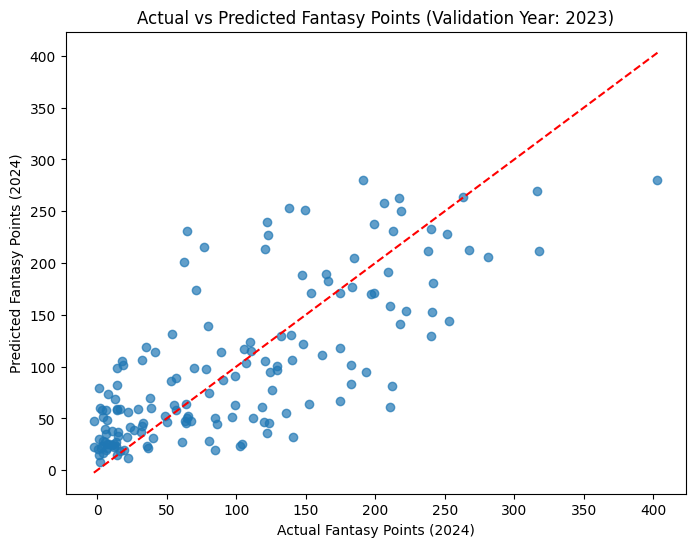

In [724]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_val, val_preds, alpha=0.7)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # perfect prediction line
plt.xlabel("Actual Fantasy Points (2024)")
plt.ylabel("Predicted Fantasy Points (2024)")
plt.title("Actual vs Predicted Fantasy Points (Validation Year: 2023)")
plt.show()

In [736]:
# Get feature importances
importance = model.feature_importances_

# Put into a DataFrame for readability
importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print(importances_df.head(15))  # Top 15 features

              Feature  Importance
3             Yds_Rec    0.322328
2                 Rec    0.204282
1                 Tgt    0.064668
5                  TD    0.051637
16  Yds_rec_last_year    0.040679
15      Rec_last_year    0.032899
17    Yds_rec_2_years    0.026848
18        Rec_2_years    0.026816
11     Career_Avg_PPR    0.021866
9           TM SNAP %    0.019997
14      Tgt_last_year    0.019802
0                 Age    0.019498
6        TD_last_year    0.019250
10         Career_Tgt    0.017269
8         Total_Snaps    0.017219


#### 2025 Predictions

In [725]:
future_preds = model.predict(X_test)
WRs_test['2025_Fantasy_Projection'] = future_preds

/var/folders/c4/n46xtynn6dzcwnjhrstwv38w0000gn/T/ipykernel_13426/1016118979.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WRs_test['2025_Fantasy_Projection'] = future_preds


## TEs Model

## Creating Features

In [673]:
TEs = TEs.sort_values(['Player', 'Year'])

In [674]:
# Career Stats

TEs['Career_Tgt'] = TEs.groupby('Player')['Tgt'].cumsum().shift(1)
TEs['Career_Tgt'] = TEs['Career_Tgt'].fillna(0)

TEs['Career_Avg_PPR'] = TEs.groupby('Player')['PPR'].expanding().mean().shift(1).reset_index(level=0, drop=True)
TEs['Career_Avg_PPR'] = TEs['Career_Avg_PPR'].fillna(0)

TEs['Career_Avg_Yds_per_rec'] = TEs.groupby('Player')['Yds_per_rec'].expanding().mean().shift(1).reset_index(level=0, drop=True)
TEs['Career_Avg_Yds_per_rec'] = TEs['Career_Avg_Yds_per_rec'].fillna(0)

#Lagged Stats
TEs['Att_Rush_last_year'] = TEs.groupby('Player')['Att_Rush'].shift(1)
TEs['Att_Rush_2_years'] = TEs.groupby('Player')['Att_Rush'].shift(2)

TEs['Yds_Rush_last_year'] = TEs.groupby('Player')['Yds (Rush)'].shift(1)
TEs['Yds_Rush_2_years'] = TEs.groupby('Player')['Yds (Rush)'].shift(2)

TEs['TD_last_year'] = TEs.groupby('Player')['TD'].shift(1)
TEs['TD_2_years'] = TEs.groupby('Player')['TD'].shift(2)

TEs['Snaps_last_year'] = TEs.groupby('Player')['Total_Snaps'].shift(1)
TEs['Snaps_2_years'] = TEs.groupby('Player')['Total_Snaps'].shift(2)

TEs['Tgt_last_year'] = TEs.groupby('Player')['Tgt'].shift(1)
TEs['Tgt_2_years'] = TEs.groupby('Player')['Tgt'].shift(2)

TEs['Rec_last_year'] = TEs.groupby('Player')['Rec'].shift(1)
TEs['Rec_2_years'] = TEs.groupby('Player')['Rec'].shift(2)

TEs['Yds_rec_last_year'] = TEs.groupby('Player')['Yds_Rec'].shift(1)
TEs['Yds_rec_2_years'] = TEs.groupby('Player')['Yds_Rec'].shift(2)

#Lagged Fantasy Points for Testing
TEs['PPR_next_year'] = TEs.groupby('Player')['PPR'].shift(-1)
TEs_train = TEs[TEs['Year'] < 2023].dropna(subset=['PPR_next_year'])
TEs_val = TEs[TEs['Year'] == 2023].dropna(subset=['PPR_next_year'])
TEs_test = TEs[TEs['Year'] == 2024]

In [ ]:
TEs_Features = ['Age', 'Tgt', 'Rec', 'Yds_Rec', 'Yds_per_rec',
                'TD', 'TD_last_year',
                # 'TD_2_years',
                'Total_Snaps', 'TM SNAP %','Career_Tgt', 'Career_Avg_PPR', 'Career_Avg_Yds_per_rec',
                'Snaps_last_year', 'Tgt_last_year', 'Rec_last_year','Yds_rec_last_year',
                'Yds_rec_2_years','Rec_2_years','Tgt_2_years','Snaps_2_years',
                ]

X_train, y_train = TEs_train[TEs_Features], TEs_train['PPR_next_year']
X_val, y_val = TEs_val[TEs_Features], TEs_val['PPR_next_year']
X_test       = TEs_test[TEs_Features]

#### Creating the model

In [704]:
model = xgb.XGBRegressor(
    n_estimators = 170,
    learning_rate = 0.05,
    max_depth = 3,
    subsample = 0.8,
    colsample_bytree = 0.8,
    reg_lambda = 10,
    reg_alpha = 0,
    random_state =6
)

model.fit(X_train,y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [705]:
# Training predictions
train_preds = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
train_r2 = r2_score(y_train, train_preds)

# Validation predictions
val_preds = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
val_r2 = r2_score(y_val, val_preds)

print("Training RMSE:", train_rmse)
print("Training R²:", train_r2)
print("Validation RMSE:", val_rmse)
print("Validation R²:", val_r2)

Training RMSE: 31.321780317602833
Training R²: 0.7468469600596005
Validation RMSE: 42.28136299210518
Validation R²: 0.5264286690687668


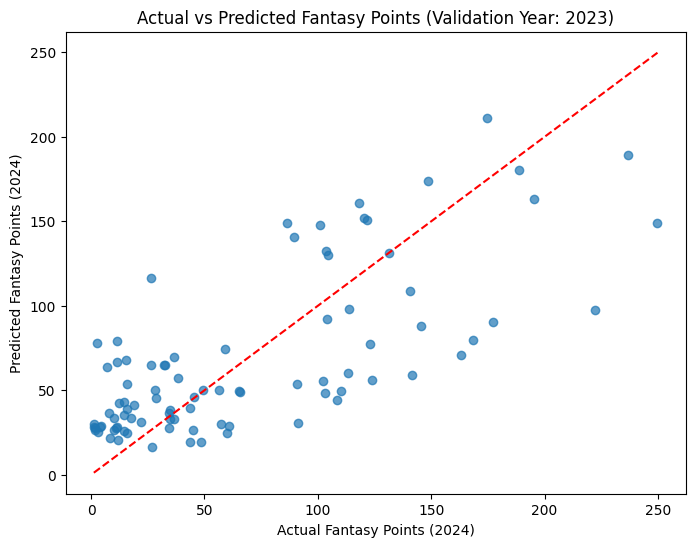

In [706]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_val, val_preds, alpha=0.7)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # perfect prediction line
plt.xlabel("Actual Fantasy Points (2024)")
plt.ylabel("Predicted Fantasy Points (2024)")
plt.title("Actual vs Predicted Fantasy Points (Validation Year: 2023)")
plt.show()

In [707]:
# Get feature importances
importance = model.feature_importances_

# Put into a DataFrame for readability
importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print(importances_df.head(15))  # Top 15 features

              Feature  Importance
3             Yds_Rec    0.257806
1                 Tgt    0.177886
2                 Rec    0.074312
12      Rec_last_year    0.043424
16        Tgt_2_years    0.043369
13  Yds_rec_last_year    0.041661
6           TM SNAP %    0.038162
4         Yds_per_rec    0.037632
11      Tgt_last_year    0.037012
8      Career_Avg_PPR    0.035307
5         Total_Snaps    0.033173
17      Snaps_2_years    0.029714
10    Snaps_last_year    0.027168
0                 Age    0.026899
14    Yds_rec_2_years    0.025238


#### 2025 Predictions TEs

In [708]:
future_preds = model.predict(X_test)
TEs_test['2025_Fantasy_Projection'] = future_preds

/var/folders/c4/n46xtynn6dzcwnjhrstwv38w0000gn/T/ipykernel_13426/1835647429.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TEs_test['2025_Fantasy_Projection'] = future_preds


In [360]:
QBs_test['Pos'] = 'QB'
RBs_test['Pos'] = 'RB'
WRs_test['Pos'] = 'WR'
TEs_test['Pos'] = 'TE'

/var/folders/c4/n46xtynn6dzcwnjhrstwv38w0000gn/T/ipykernel_13426/2802477683.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  QBs_test['Pos'] = 'QB'
/var/folders/c4/n46xtynn6dzcwnjhrstwv38w0000gn/T/ipykernel_13426/2802477683.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RBs_test['Pos'] = 'RB'
/var/folders/c4/n46xtynn6dzcwnjhrstwv38w0000gn/T/ipykernel_13426/2802477683.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [396]:
all_players = pd.concat([RBs_test, WRs_test, TEs_test], ignore_index=True)

In [370]:
RBs_test[RBs_test['Player'] == "JAVONTE WILLIAMS"]

,Player,Tm,Age,G,GS,Att_Rush,Yds (Rush),Y/A,TD (Rush),Tgt,Rec,Yds_Rec,Yds_per_rec,TD (Rec),Fmb,FL,TD,2PM,2PP,PPR,Total_Snaps,Avg Snaps,TM SNAP %,PPR_Rush,PPR_RushAtt,Tot_PPR_Rec,PPR_Tgt,Tgt_gm,PPR_Rec,PPR_Snap,Year,Career_Att_Rush,Career_Avg_PPR,Career_Avg_Y/A,Att_Rush_last_year,Yds_Rush_last_year,TD_last_year,Snaps_last_year,Tgt_last_year,Rec_last_year,Yds_rec_last_year,PPR_next_year,2025_Fantasy_Projection
32,JAVONTE WILLIAMS,DEN,24.0,17.0,11.0,139.0,513.0,3.69,4.0,70.0,52.0,346.0,6.65,0.0,2.0,2.0,4.0,0.0,0.0,157.9,574,33,52.1,75.3,0.541727,86.6,1.237143,4.117647,1.665385,0.275087,2024,467.0,142.033333,4.12,217.0,774.0,5.0,493.0,58.0,47.0,228.0,NaN,152.959457
